In [13]:
import numpy as np
import pandas as pd
from matplotlib import animation, rc
from IPython.display import HTML
import os
import glob
#import quaternion
import matplotlib.pyplot as plt
import json
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import animation, rc, cm
import seaborn as sns
import imageio.v2 as imageio
import ast
import time

ModuleNotFoundError: No module named 'quaternion'

In [2]:
#set directories
direc = '/Users/catherinekim/Desktop/VRTL_copy'

order = ["dummy","G,W,C,C,G,W","G,C,W,W,G,C","W,G,C,C,W,G","W,G,C,C,G,W","C,G,W,W,C,G",
         "C,G,W,W,G,C","C,W,G,G,C,W","C,W,G,G,W,C","G,W,C,C,W,G","G,C,W,W,C,G",
         "G,W,C,C,G,W"] #append participant order
order_list = [item.split(',') for item in order]

    

In [3]:
def parse_camera_location(s):
    location = np.array(ast.literal_eval(s[0])) #camera location
    orientation = np.array(ast.literal_eval(s[1])) #quaternion rotation
    flip = np.array(ast.literal_eval(s[2])) #origin space
    return location, orientation, flip 
    #return np.array(ast.literal_eval(s[0])), np.array(ast.literal_eval(s[1]))

def load_camera_location(direc): #Loads the file VRTL_CameraLocations.txt and parses it into camera name + location
    with open(direc + 'zombie_CameraLocations.txt') as f:
        lines = f.read().splitlines()
        camera_locations = {}
        
        for line in lines:
            parts = line.split('\t')
            
            if len(parts) < 3:
                continue  # Skip this line
            
            # Use the first part for the camera name, and parse the remaining two parts
            name = parts[0]
            location, orientation,flip = parse_camera_location(parts[1:4])
            camera_locations[name] = (location, orientation,flip)
        
        return camera_locations
    

In [4]:
def quaternion_conjugate(q):
    """ Return the conjugate of a quaternion. """
    w, x, y, z = q
    return np.array([w, -x, -y, -z])

def rotate_vectors(q, vectors):
    """ Rotate multiple vectors by quaternion q. """
    q_conj = quaternion_conjugate(q)
    # Convert vectors to quaternion format with zero scalar part
    v_quat = np.hstack([np.zeros((vectors.shape[0], 1)), vectors])
    # Quaternion multiplication: q * v * q_conj
    v_rot = np.array([quaternion_multiply(quaternion_multiply(q, v), q_conj) for v in v_quat])
    return v_rot[:, 1:]  # return vector part only

def quaternion_multiply(q1, q2):
    """ Multiply two quaternions. """
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1*w2 - x1*x2 - y1*y2 - z1*z2
    x = w1*x2 + x1*w2 + y1*z2 - z1*y2
    y = w1*y2 - x1*z2 + y1*w2 + z1*x2
    z = w1*z2 + x1*y2 - y1*x2 + z1*w2
    return np.array([w, x, y, z])

#convert to polar
def convert_to_polar(A):
    """
    Converts an array of normalized vectors in a user-centric cartesian
    coordinates to a polar representation. In cartesian coordinates (x,y,z),
    the z-coordinate is the user's forward, the y-direction is upwards and x
    is lateral. In polar coordinates, the first angle is aximuth, elevation
    """
    return np.hstack([np.arctan2(A[:,0],A[:,2])[:,None],np.arcsin(A[:,1])[:,None]])

def ready_for_fixations(A,B):
    df = pd.DataFrame(index=np.arange(B.size/2), columns = np.arange(7)) #B.size is twice of what we want. So have to /2
    df.columns = ['timepoint','x_pos_pixel', 'y_pos_pixel', 'r_polar', 'theta_polar','lat','long']
    df.timepoint = pd.Series(range(0,len(B)))
    df['r_polar'] = B[:,0]
    df['theta_polar'] = B[:,1]
    df['lat'] = np.rad2deg(B[:,1]) + 90
    df['long'] = np.rad2deg(B[:,0]) + 180
    df['x_pos_pixel'] = np.round((B[:,0]+np.pi)*(4096/np.pi)) 
    df['y_pos_pixel'] = np.round((-B[:,1]+np.pi/2)*(4096/np.pi)) # check for -theta or regular theta
    return df


In [5]:
#extract fixations
def idt(time, x, y, max_disp): 
    #set up parameters
    s_freq = 120  # Sampling frequency.
    min_dur_ms = 88  # Minimum fixation duration (in ms).
    min_dur_samples = np.floor(min_dur_ms * s_freq / 1000).astype(int)

    # Initialize variables
    fix_start = []
    fix_end = []
    # fix_x = []
    # fix_y = []
    start = 0  # window start position

    while start <= len(x) - min_dur_samples:
        # Window end position
        end = start + min_dur_samples
        
        # Create window        
        x_win = x[start:end]
        y_win = y[start:end]

        # Dispersion
        D = (np.nanmax(x_win) - np.nanmin(x_win)) + (np.nanmax(y_win) - np.nanmin(y_win))

        j = 1  # Window expander

        while D <= max_disp and end + j <= len(x):
            # Expand window
            x_win = x[start:end + j]
            y_win = y[start:end + j]

            D = (np.nanmax(x_win) - np.nanmin(x_win)) + (np.nanmax(y_win) - np.nanmin(y_win))

            if D > max_disp:
                # Select window (j - 1) as fixation
                fix_start.append(time[start])
                fix_end.append(time[end + j - 1])
                # fix_x.append(np.nanmean(x_win[:-1])) # don't necessarily need x & y as we just need duration + fixation indexes.
                # fix_y.append(np.nanmean(y_win[:-1]))
                start = end + j  # Skip window points
                break

            elif end + j == len(x):
                # Handle last window if data ends during a fixation
                fix_start.append(time[start])
                fix_end.append(time[end])
                # fix_x.append(np.nanmean(x_win))
                # fix_y.append(np.nanmean(y_win))
                start = end + j
                break
            j += 1
        start += 1

    # Create result dataframe
    extracted_fixations = pd.DataFrame({
        'start': fix_start,
        'end': fix_end,
        'dur': np.array(fix_end) - np.array(fix_start),
    })

    return extracted_fixations

In [6]:
# gaze visualization

def get_visualization(par, s, wrap_pattern, camera, gaze_fixations, extracted_fixations):
    im = imageio.imread(f"/Users/catherinekim/Desktop/VRTL/Wraparounds/{wrap_pattern}_{camera}.png")
    heatmap_x = []
    heatmap_y = []
    x_cam = gaze_fixations['x_pos_pixel']
    y_cam = gaze_fixations['y_pos_pixel']
    n_samples = len(gaze_fixations)
    cm_subsection = np.linspace(0.0, 1.0, n_samples)
    colors = [cm.plasma(x) for x in cm_subsection]

    fig = plt.figure()
    fig.set_size_inches(16,8)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    fig.add_axes(ax)

    # Equirect first
    ax.imshow(im,aspect='auto')

    for i, color in enumerate(colors):
    #Plot gaze points.
        ax.plot(x_cam[i],y_cam[i],'.',markersize=3,color=color);
    #Plot connecting line. 
        if i < n_samples:
            ax.plot(x_cam[i:i+2],y_cam[i:i+2],'-',linewidth= 1 ,color=color);
    
    #plot fixations
    for j in range(len(extracted_fixations)):
    #Plot points. 
        start = extracted_fixations.iloc[j]['start']
        end = extracted_fixations.iloc[j]['end']
        durations = extracted_fixations.loc[j]['dur']
    
    # Extract the x and y coordinates for this fixation
        x_coords = gaze_fixations.loc[start:end, 'x_pos_pixel'].values
        y_coords = gaze_fixations.loc[start:end, 'y_pos_pixel'].values
        sizes = durations * 10

        heatmap_x.extend(x_coords)
        heatmap_y.extend(y_coords)

        heatmap_df = pd.DataFrame({'x_coords': heatmap_x, 
                               'y_coords': heatmap_y
                               })
   
        ax.scatter(x_coords, y_coords, s=sizes, color='black', alpha=0.4)
        
        #heatmap_x.append(np.array(x_coords).T)
        #heatmap_y.append(np.array(y_coords).T)

        heatmap_df.to_csv(f"{direc}/heatmap_test{s}_{camera}.csv", index=0)

    ax.set_axis_off()
    
    #output_file = os.path.join(output_dir, f"{camera}_data.csv")
    if s in range(1,4):
        plt.savefig(f"{direc}/VRTL{par}/Visualizations/{wrap_pattern}_{camera}_visualization.png", bbox_inches='tight', pad_inches=0)
        plt.close() #save memory
        print(f"Saved visualization to {direc}/VRTL{par}/Visualizations/{wrap_pattern}_{camera}_visualization.png")
    elif s == 4:
        plt.savefig(f"{direc}/VRTL{par}/Visualizations/fear_{wrap_pattern}_{camera}_visualization.png", bbox_inches='tight', pad_inches=0)
        plt.close()
        print(f"Saved visualization to {direc}/VRTL{par}/Visualizations/fear_{wrap_pattern}_{camera}_visualization.png")
    elif s in range(5,7):
        plt.savefig(f"{direc}/VRTL{par}/Visualizations/test_{wrap_pattern}_{camera}_visualization.png", bbox_inches='tight', pad_inches=0)
        plt.close() 
        print(f"Saved visualization to {direc}/VRTL{par}/Visualizations/test_{wrap_pattern}_{camera}_visualization.png")
    return heatmap_df


In [7]:
#compute entropy
def compute_entropy(camera, heatmap_df):
    #coordinates = list(zip(heatmap_df['x_pos_pixel'], heatmap_df['y_pos_pixel']))
    coordinates = list(zip(heatmap_df['x_coords'], heatmap_df['y_coords']))
    values, counts = np.unique(coordinates,return_counts=True)
    probabilities = counts / counts.sum()
    entropy = -np.sum(probabilities * np.log2(probabilities))
    print(f"{camera} entropy : {entropy}")
    return entropy

In [ ]:
def rotate_gaze(head,gaze):
    """
    Computes egocentric gaze coordinates for a matrix of head orientations and
    gaze directions (assumed to be same size)
    """
    return np.array([qt.rotate_vectors(q.inverse(),v)
                      for q,v in zip(convert_to_quaternion(head),gaze)])

def convert_to_quaternion(A):
    """
    Converts an N-by-4 array to an N-by-1 array of quaternions

    Note the cycling of indices which is necessary since Unity encodes the
    quaternion a + b*i + c*j + d*k as (b,c,d,a) whereas Python encodes it as
    (a,b,c,d)
    """
    return qt.as_quat_array(np.hstack([A[:,3:],A[:,:3]]))


In [8]:
def process_gaze(par, s, session_ID, wrap_pattern, cam_locations):
    entropies = []
    for camera, coords in cam_locations.items():
        pattern = f"{direc}/filtered_camera_data/VRTL{par}/{session_ID}_{camera}.csv"
        matching_files = glob.glob(pattern)

        if not matching_files:
            print(f"No matching files found")
        
        for filename in matching_files:
            specific_cam = pd.read_csv(filename)
            
            #gaze = np.array(specific_cam[[" tobii_world_gaze_direction.x", " tobii_world_gaze_direction.y", " tobii_world_gaze_direction.z"]])
            gaze = np.array(specific_cam[[" tobii_world_direction.x", " tobii_world_direction.y", " tobii_world_direction.z"]])
            rotation= np.array(coords[1]) # quaternion rotation 
            flip = np.array(coords[2]) #origin flipping 
            gaze[:,0]*= flip[0]
            gaze[:,1]*= flip[1]
            gaze[:,2]*= flip[2]
            norm = np.linalg.norm(rotation)
            camera_rotation = rotation / norm
            #rotate gaze 
            rotated_gaze = rotate_vectors(camera_rotation, gaze) 
            #convert to polar
            gaze_polar = convert_to_polar(rotated_gaze) 
            #get dataset ready for fixations extraction (A,B) A= size of B
            gaze_fixations = ready_for_fixations(gaze[:,0],gaze_polar)  #raw gaze patterns
            # Run the fixation extraction.
            
            extracted_fixations = idt(gaze_fixations['timepoint'], gaze_fixations['long'], gaze_fixations['lat'], max_disp = 3) #
            heatmap_df = get_visualization(par, s, wrap_pattern, camera, gaze_fixations, extracted_fixations)
            gaze_fixations.to_csv(f"{direc}/gaze_fixations_test.csv", index=False)
            extracted_fixations.to_csv(f"{direc}/extracted_fixations_test.csv", index=False)
            entropy = compute_entropy(camera, heatmap_df)
            entropies.append(entropy)
    return entropies
            

In [ ]:
#11 participants + 6 sessions

for par in range(11,12):
    entropy_list = []
    for s in range(1,7): #get all 5 sessions including 2 tests
        session_ID = f"VRTL{par}S{s}"
        raw_file = f"{direc}/VRTL{par}/eyetracking/{session_ID}.txt"
        
        if not os.path.exists(raw_file):
            print(f"Warning: {raw_file} does not exist.")
            continue
 
        raw_data = pd.read_csv(raw_file)

        # #data = raw_data[raw_data[' distance_valid_C'] != False]
        data = raw_data[raw_data[' validity'] != False] #delete invalid values
        wrap_pattern = order_list[par][s-1]

        # seprating by camera locations
        cam_locations = load_camera_location('/Users/catherinekim/Desktop/VRTL/')

        cam_dir = f"{direc}/filtered_camera_data/VRTL{par}"
  
        if not os.path.exists(cam_dir):
            os.makedirs(cam_dir)
                
        tolerance = 0.5 # allow some flexibility in camera coordinates
        for camera, coords in cam_locations.items():
            dir_x,dir_y,dir_z = coords[0]
            
            camera_data = data[
                # (abs(data[' camPos_x'] - dir_x) <= tolerance) &
                # (abs(data[' camPos_y'] - dir_y) <= tolerance) &
                # (abs(data[' camPos_z'] - dir_z) <= tolerance)]
                (abs(data[' tobii_world_origin.x'] - dir_x) <= tolerance) &
                (abs(data[' tobii_world_origin.y'] - dir_y) <= tolerance) &
                (abs(data[' tobii_world_origin.z'] - dir_z) <= tolerance)]
            
            cam_file = os.path.join(cam_dir, f"{session_ID}_{camera}.csv")
            camera_data.to_csv(cam_file, index=False)

        entropies = process_gaze(par, s, session_ID, wrap_pattern, cam_locations)
            
        with open(f"{direc}/VRTL{par}/VRTL{par}_entropy.txt", "a") as output:
            for camera, entropy in zip(cam_locations.keys(), entropies):
                output.write(f"{session_ID}_{camera}:{entropy}\n")  # Write each entry on a new line

        

In [37]:
zombie_data = pd.read_csv("/Users/catherinekim/Desktop/Cabin_zombie.txt")

        # #data = raw_data[raw_data[' distance_valid_C'] != False]
        # seprating by camera locations

tolerance = 0.5 # allow some flexibility in camera coordinates

#camera rotation
dir_x = -3.26
dir_y = 1.7
dir_z = 4.53

camera_data = zombie_data[
    (abs(zombie_data[' validity'] - dir_x) <= tolerance) &
    (abs(zombie_data[' camPos_x'] - dir_y) <= tolerance) &
    (abs(zombie_data[' camPos_y'] - dir_z) <= tolerance)]
                
        
cam_file = os.path.join("/Users/catherinekim/Desktop/Cabin_zombie_camera.csv")
camera_data.to_csv(cam_file, index=False)


In [78]:
cabin_zombie = pd.read_csv("/Users/catherinekim/Desktop/Cabin_zombie_camera.csv")

In [123]:
cabin_zombie_df = np.array(cabin_zombie[[' zombie_x',' zombie_y',' zombie_z']])

In [124]:
df = cabin_zombie_df

In [125]:
zombie_coords = (-3.26, 1.700000, 4.53)
#zombie_rot = (0.9603, 0.000000, 0.2788, 0.0000)
#zombie_rot = (0, 0.9603, 0, 0.2788)
zombie_rot = (0, 0.2788, 0, 0.9603)
norm = np.linalg.norm(zombie_rot)
zombie_rotation = zombie_rot / norm
zombie_origin = cabin_zombie_df - zombie_coords


In [126]:
zombie_rotation = zombie_rot / norm
zombie_origin = cabin_zombie_df - zombie_coords

In [127]:
zombie = pd.DataFrame(rotate_vectors(zombie_rotation,zombie_origin))

In [76]:
zombie.to_csv('/Users/catherinekim/Desktop/test_zombie.csv')

In [128]:
df = zombie

,0,1,2
0,-11.510544,1.2,-0.799035
1,-11.510544,1.2,-0.799035
2,-11.510544,1.2,-0.799035
3,-11.510544,1.2,-0.799035
4,-11.510544,1.2,-0.799035
...,...,...,...
7379,-12.812356,1.7,-0.246508
7380,-12.812356,1.7,-0.246508
7381,-12.812356,1.7,-0.246508
7382,-12.812356,1.7,-0.246508


In [129]:
#normalize
df['magnitude'] = np.sqrt(df[0]**2 + df[1]**2 + df[2]**2)

# Normalize each vector component (x, y, z) by dividing by the magnitude
df['x_unit'] = df[0] / df['magnitude']
df['y_unit'] = df[1] / df['magnitude']
df['z_unit'] = df[2] / df['magnitude']

# Display the DataFrame with unit vectors
#import ace_tools as tools; tools.display_dataframe_to_user(name="Unit Vectors DataFrame", dataframe=df)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [114]:
rotated_gaze = np.array(df[['x_unit','y_unit','z_unit']])

In [115]:
gaze_polar = convert_to_polar(rotated_gaze) 
            #get dataset ready for fixations extraction (A,B) A= size of B
#gaze_fixations = ready_for_fixations(gaze[:,0],gaze_polar)  #raw gaze patterns
            # Run the fixation extraction.

In [116]:
def ready_for_fixations(B):
    df = pd.DataFrame(index=np.arange(B.size/2), columns = np.arange(7)) #B.size is twice of what we want. So have to /2
    df.columns = ['timepoint','x_pos_pixel', 'y_pos_pixel', 'r_polar', 'theta_polar','lat','long']
    df.timepoint = pd.Series(range(0,len(B)))
    df['r_polar'] = B[:,0]
    df['theta_polar'] = B[:,1]
    df['lat'] = np.rad2deg(B[:,1]) + 90
    df['long'] = np.rad2deg(B[:,0]) + 180
    df['x_pos_pixel'] = np.round((B[:,0]+np.pi)*(4096/np.pi)) 
    df['y_pos_pixel'] = np.round((-B[:,1]+np.pi/2)*(4096/np.pi)) # check for -theta or regular theta
    return df

In [120]:
testtt = ready_for_fixations(gaze_polar)

In [121]:
testtt

,timepoint,x_pos_pixel,y_pos_pixel,r_polar,theta_polar,lat,long
0.0,0,7708.0,2183.0,2.770335,-0.103629,84.062472,338.728501
1.0,1,7708.0,2183.0,2.770335,-0.103629,84.062472,338.728501
2.0,2,7708.0,2183.0,2.770335,-0.103629,84.062472,338.728501
3.0,3,7708.0,2183.0,2.770335,-0.103629,84.062472,338.728501
4.0,4,7708.0,2183.0,2.770335,-0.103629,84.062472,338.728501
...,...,...,...,...,...,...,...
7379.0,7379,7643.0,2220.0,2.720266,-0.131890,82.443272,335.859762
7380.0,7380,7643.0,2220.0,2.720266,-0.131890,82.443272,335.859762
7381.0,7381,7643.0,2220.0,2.720266,-0.131890,82.443272,335.859762
7382.0,7382,7643.0,2220.0,2.720266,-0.131890,82.443272,335.859762


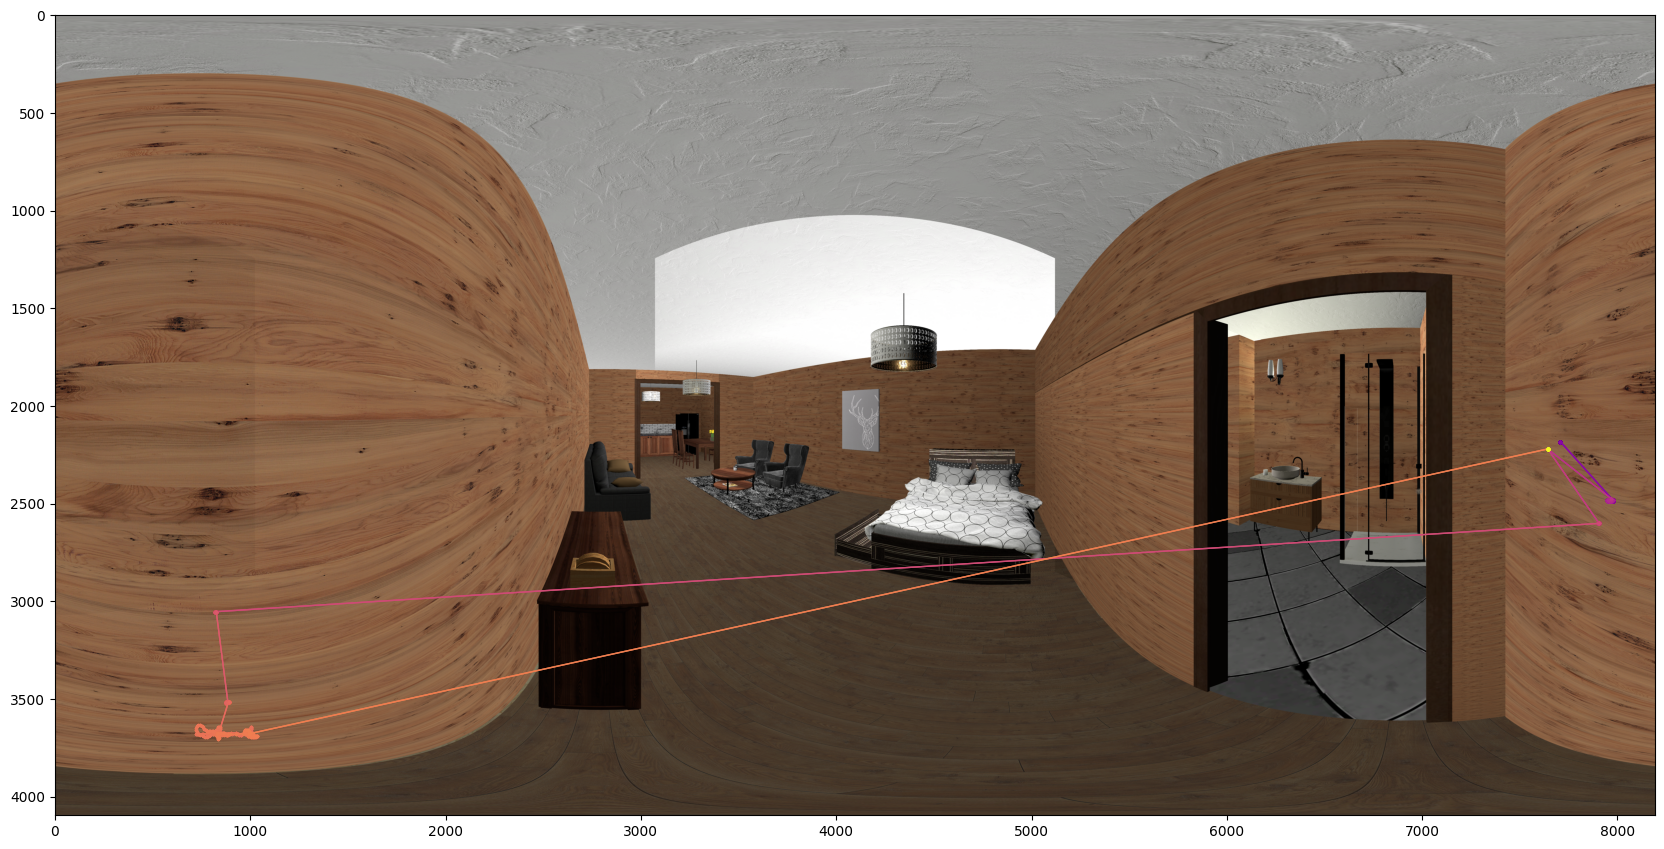

In [122]:
im = imageio.imread(f"/Users/catherinekim/Desktop/C_Camera6.png")

x_cam = testtt['x_pos_pixel']
y_cam = testtt['y_pos_pixel']
n_samples = len(testtt)
cm_subsection = np.linspace(0.0, 1.0, n_samples)
colors = [cm.plasma(x) for x in cm_subsection]

fig = plt.figure()
fig.set_size_inches(16,8)
ax = plt.Axes(fig, [0., 0., 1., 1.])
fig.add_axes(ax)

    # Equirect first
ax.imshow(im,aspect='auto')

for i, color in enumerate(colors):
    #Plot gaze points.
    ax.plot(x_cam[i],y_cam[i],'.',markersize=3,color=color);
    #Plot connecting line. 
    if i < n_samples:
        ax.plot(x_cam[i:i+2],y_cam[i:i+2],'-',linewidth= 1 ,color=color);

gaze world coordinates --> rotate to be in origin space --> convert to polar (r, theta)--> convert to pixel coordinates

In [25]:
#Grid entropy calculation
# Define the grid size
grid_width = 64  # Adjust based on your desired grid size
grid_height = 32  # Adjust based on your desired grid size

# Divide the coordinates by the grid size to find the grid cell each point falls into
x_bins = (gaze_fixations['x_pos_pixel'] // grid_width).astype(int)
y_bins = (gaze_fixations['y_pos_pixel'] // grid_height).astype(int)

# Combine these into a single identifier for each grid cell
grid_cells = list(zip(x_bins, y_bins))

# Calculate the frequency of each grid cell
unique_cells, counts = np.unique(grid_cells, return_counts=True)

# Calculate the probabilities
probabilities = counts / counts.sum()

# Calculate Shannon's entropy using the grid method
entropy = -np.sum(probabilities * np.log2(probabilities))


5.27345963592524

In [ ]:
df = pd.DataFrame({'Day':day, 'x':np.reshape(x, 90, order='F'),
                  'y':np.reshape(y, 90, order='F')})
df.head()

In [12]:
#extract zombie location


'/Users/catherinekim/Desktop/VRTL'

In [ ]:
entro_df = pd.read_csv(f"{direc}/entropy.csv',index_col=F0)